## Train the model with small train set
All functions, like **get_bow_representation()** and **get_vocabulary()**, offer the possibility to store the result into a file by passing the parameter **'save=True'**

In [17]:
import build_vocabulary as bv
import features_extraction as fe
import train_classifier as tc

iterations=[]
types=[]
test_accuracy=[]
train_accuracy=[]
for iter in range (250,5000,250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    train_data = fe.get_bow_representation(voc, path='../data/train')
    w, b = tc.train_classifier(train_data)

    predictions, accuracy_train = tc.inference_classifier(train_data, w, b)
    
    iterations.append(iter)
    types.append('classic model')
    train_accuracy.append(accuracy_train)
    
    test_data = fe.get_bow_representation(voc, path='../data/test')
    predictions, accuracy_test = tc.inference_classifier(test_data, w, b)
    test_accuracy.append(accuracy_test)

## The model ignores very common words

In [19]:
words_to_ignore=[]
f = open('../data/stopwords.txt', 'r')
n = 0
for w in f.read().split():
    words_to_ignore.append(w)
    n += 1
f.close()
for iter in range (250,5000,250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    voc_no_common_words = [word for word in voc if word not in words_to_ignore]

    train_data = fe.get_bow_representation(voc_no_common_words)
    w, b = tc.train_classifier(train_data)

    predictions, accuracy_train = tc.inference_classifier(train_data, w, b)

    iterations.append(iter)
    types.append('Model without common words')
    train_accuracy.append(accuracy_train)
    
    test_data = fe.get_bow_representation(voc_no_common_words, path='../data/test')
    predictions, accuracy_test = tc.inference_classifier(test_data, w, b)
    test_accuracy.append(accuracy_test)

## Model with stemming

In [21]:
for iter in range (250,5000,250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)

    voc_stem = fe.stem_words(voc)
    train_data = fe.get_bow_representation(voc_stem, stemming=True)
    w, b = tc.train_classifier(train_data)

    predictions, accuracy_train = tc.inference_classifier(train_data, w, b)

    iterations.append(iter)
    types.append('Model with stemming')
    train_accuracy.append(accuracy_train)
    
    test_data = fe.get_bow_representation(
        voc_stem, path='../data/test', stemming=True)
    predictions, accuracy_test = tc.inference_classifier(test_data, w, b)
    test_accuracy.append(accuracy_test)
  

## Model with stemming and ignore common words

In [23]:
for iter in range (250,5000,250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    voc_no_common_words = [word for word in voc if word not in words_to_ignore]

    voc_stem_no_cwords = fe.stem_words(voc_no_common_words)
    
    train_data = fe.get_bow_representation(voc_stem_no_cwords, stemming=True)
    w, b = tc.train_classifier(train_data)

    predictions, accuracy_train = tc.inference_classifier(train_data, w, b)
    
    iterations.append(iter)
    types.append('Model with stemming and without common words')
    train_accuracy.append(accuracy_train)
    
    test_data = fe.get_bow_representation(
        voc_stem_no_cwords, path='../data/test', stemming=True)
    predictions, accuracy_test = tc.inference_classifier(test_data, w, b)
    test_accuracy.append(accuracy_test)

## Compare different models

<Axes: title={'center': 'Test accuracy for different models'}, xlabel='iterations'>

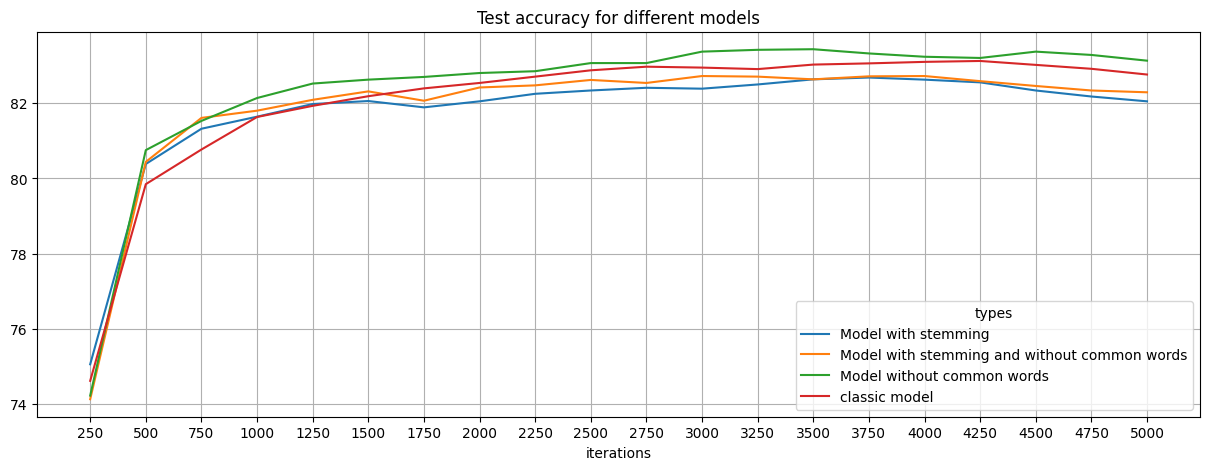

In [38]:
import pandas as pd
results=pd.DataFrame({'iterations':iterations,'types':types,'test_accuracy':test_accuracy,'train_accuracy':train_accuracy})
results=results.pivot(index='iterations',columns='types',values='test_accuracy')
results.to_csv('results.csv',index=True)
results.plot(kind='line',title='Test accuracy for different models',legend=True,grid=True,figsize=(15,5),xticks=range(250,5250,250))